<a href="https://colab.research.google.com/github/gh0st-kid/TimeSeries_Analysis_and_Forecasting/blob/main/TS_model_SARIMAX(q).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                             mean_absolute_percentage_error)
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
import logging

In [ ]:
warnings.filterwarnings("ignore")
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

In [ ]:
def check_versions():
  print(f'Pandas версия: {pd.__version__}')
  print(f'Numpy версия: {np.__version__}')
  print(f'Matplotlib версия: {plt.matplotlib.__version__}')
  print(f'Seaborn версия: {sns.__version__}')
  print(f'Scikit-learn версия: {sklearn.__version__}')
  print(f'Statsmodels версия: {sm.__version__}')
  print(f'Библиотеки успешно импортированы.')

check_versions()

Pandas версия: 2.2.2
Numpy версия: 1.26.4
Matplotlib версия: 3.7.1
Seaborn версия: 0.13.1
Scikit-learn версия: 1.5.2
Statsmodels версия: 0.14.4
Библиотеки успешно импортированы.


In [ ]:
def load_and_prepare_data(file_path):
    """
    Загружает и подготавливает данные из CSV файла.

    Аргументы:
    file_path : str
        Путь к CSV файлу с данными.

    Возвращает:
    pandas.DataFrame
        Подготовленный датафрейм с данными, где:
        - Удалены пробелы из названий столбцов.
        - Столбец 'year' преобразован в кварталы и удалён.
        - Все числовые столбцы преобразованы в тип float.
        - Данные отсортированы по кварталу.
    """

    df = pd.read_csv(file_path, delimiter=',')

    # Удаление пробелов из названий столбцов
    df.columns = df.columns.str.strip()

    # Преобразование столбца 'year' в даты
    df['year'] = pd.to_datetime(df['year'], format='%m/%d/%Y')

    # Преобразование даты в кварталы
    df['quarter'] = df['year'].dt.to_period('Q')

    # Преобразование числовых столбцов
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
    df[numeric_columns] = df[numeric_columns].astype(float)

    # Сортировка по кварталам
    df.sort_values('quarter', inplace=True)

    # Удаление столбца 'year' и установка квартала в качестве индекса
    df.drop(columns=['year'], inplace=True)  # Удаляем столбец 'year'
    df.set_index('quarter', inplace=True)    # Устанавливаем 'quarter' в качестве индекса

    # Преобразование индекса из PeriodIndex в DatetimeIndex
    df.index = df.index.to_timestamp()

    return df


df = load_and_prepare_data('/content/df.csv')

In [ ]:
df.head(10)

,zan(cfo),zan(szfo),zan(ufo),zan(skfo),zan(pfo),zan(uralfo),zan(sfo),zan(dfo),bezr(cfo),bezr(szfo),...,bezr(sfo),bezr(dfo),srd(cfo),srd(szfo),srd(ufo),srd(skfo),srd(pfo),srd(uralfo),srd(sfo),srd(dfo)
quarter,,,,,,,,,,,,,,,,,,,,,
2010-01-01,19402.5,7169.8,6260.5,3433.2,14150.9,5872.8,8821.8,3049.5,1143.2,524.3,...,1018.8,354.1,20994.4,17568.0,12560.4,10168.8,13275.0,19566.3,12770.6,17202.3
2010-04-01,19675.6,7175.0,6532.1,3714.1,14762.3,5988.3,9167.9,3125.1,944.4,443.9,...,894.2,291.9,25046.3,20140.8,14287.9,12212.4,15659.0,21734.1,14862.1,20543.2
2010-07-01,19895.0,7257.4,6588.1,3703.4,14957.0,6077.4,9461.4,3232.5,900.3,415.4,...,779.5,248.2,23340.4,19058.9,15746.2,13841.7,15731.1,21178.0,14817.9,20412.1
2010-10-01,19892.0,7149.9,6374.2,3703.8,14787.7,6081.8,9110.5,3161.3,855.2,427.5,...,786.9,286.0,29517.9,22802.4,17856.1,17200.4,18629.5,24847.0,17523.5,24927.0
2011-01-01,19722.3,7204.1,6415.3,3670.4,14396.5,6008.9,8923.6,3163.7,943.6,475.3,...,869.3,293.1,22688.4,19065.0,14001.0,11427.8,14494.9,20607.8,14291.7,18913.8
2011-04-01,19974.6,7260.7,6474.7,3832.3,14809.1,6141.6,9166.9,3198.5,836.4,372.5,...,836.5,233.9,27060.0,21536.3,15696.5,13579.3,16737.6,23583.6,16273.5,21702.1
2011-07-01,20342.7,7347.3,6605.1,3901.0,15057.5,6170.0,9315.7,3248.7,828.8,362.3,...,768.8,238.5,25919.8,20866.1,17494.3,15845.5,17440.6,23509.8,16274.1,22692.8
2011-10-01,20188.0,7309.3,6452.0,3762.0,14940.3,6088.5,9127.4,3207.8,821.5,354.6,...,748.3,251.8,32849.0,23565.9,19222.4,19677.1,20433.5,28153.3,19448.0,28099.1
2012-01-01,20106.7,7274.9,6406.9,3732.5,14458.1,6041.3,8898.5,3156.9,784.2,352.1,...,740.8,262.7,24303.0,19997.0,14824.0,12986.0,16201.0,22502.0,15772.0,19449.0


In [ ]:
def split_train_test_by_ratio(series, train_size=0.8):
    """
    Простое разбиение временного ряда на обучающую и тестовую выборки.

    Аргументы:
    series : pandas.Series
        Временной ряд для разбиения.
    train_size : float
        Доля данных, которая пойдет в обучающую выборку.

    Возвращает:
    train : pandas.Series
        Обучающая выборка.
    test : pandas.Series
        Тестовая выборка.
    """
    if not isinstance(series, pd.Series):
        raise TypeError("Ожидался pandas.Series на вход.")

    split_index = int(len(series) * train_size)
    train = series.iloc[:split_index]
    test = series.iloc[split_index:]
    return train, test

In [ ]:
# Проверка функции простого разбиения
print("Обычное разбиение:")
train, test = split_train_test_by_ratio(df['bezr(cfo)'], train_size=0.8)
print((train))

Обычное разбиение:
quarter
2010-01-01    1143.2
2010-04-01     944.4
2010-07-01     900.3
2010-10-01     855.2
2011-01-01     943.6
2011-04-01     836.4
2011-07-01     828.8
2011-10-01     821.5
2012-01-01     784.2
2012-04-01     641.5
2012-07-01     613.0
2012-10-01     596.9
2013-01-01     718.4
2013-04-01     667.5
2013-07-01     689.5
2013-10-01     715.8
2014-01-01     680.6
2014-04-01     652.9
2014-07-01     640.4
2014-10-01     646.3
2015-01-01     734.4
2015-04-01     763.5
2015-07-01     731.1
2015-10-01     750.4
2016-01-01     805.9
2016-04-01     774.0
2016-07-01     726.7
2016-10-01     713.3
2017-01-01     752.5
2017-04-01     688.2
2017-07-01     658.6
2017-10-01     665.2
2018-01-01     660.2
2018-04-01     618.3
2018-07-01     589.3
2018-10-01     611.9
2019-01-01     626.2
2019-04-01     602.8
Freq: QS-OCT, Name: bezr(cfo), dtype: float64


In [ ]:
def train_sarimax_model(train, p, d, q, seasonal_order=(0, 0, 0, 0)):
    """
    Обучает модель SARIMAX с заданными параметрами p, d, q и сезонными
    параметрами.

    Аргументы:
    train : pandas.Series
        Обучающая выборка временного ряда.
    p : int
        Параметр p модели SARIMAX.
    d : int
        Параметр d модели SARIMAX.
    q : int
        Параметр q модели SARIMAX.
    seasonal_order : tuple
        Сезонные параметры (P, D, Q, s).

    Возвращает:
    model : SARIMAXResultsWrapper
        Обученная модель SARIMAX.
    """
    model = SARIMAX(train, order=(p, d, q), seasonal_order=seasonal_order)
    fitted_model = model.fit(disp=False)
    return fitted_model

In [ ]:
def forecast_sarimax(series, p, d, q, P, D, Q, s, future_periods=3):
    """
    Предсказывает значения временного ряда с помощью модели SARIMAX.

    Аргументы:
    series: pandas.Series
        Временной ряд с квартальной частотой.
    p, d, q: int
        Параметры модели ARIMA.
    P, D, Q: int
        Параметры сезонной компоненты SARIMAX.
    s: int
        Период сезона (например, для квартальных данных s=4).
    future_periods: int, optional
        Количество периодов для прогнозирования после тестового периода.

    Возвращает:
    forecast: pandas.Series
        Прогноз на тестовый период.
    future_forecast: pandas.Series
        Прогноз на будущие периоды.
    conf_int: pandas.DataFrame
        Доверительные интервалы для прогнозируемых значений.
    """

    # Разделение данных на обучающую и тестовую выборки
    train, test = split_train_test_by_ratio(series)

    # Установка частоты индекса
    if test.index.freq is None:
        test = test.asfreq('Q')  # Установка квартальной частоты

    # Обучение модели SARIMAX на обучающей выборке
    model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
    model_fit = model.fit(disp=False)

    # Прогноз на тестовый период
    forecast = model_fit.get_forecast(steps=len(test))
    forecast_values = forecast.predicted_mean
    conf_int = forecast.conf_int()

    # Обновление модели на всем ряде (обучающая и тестовая выборка)
    full_model = SARIMAX(series, order=(p, d, q), seasonal_order=(P, D, Q, s))
    full_model_fit = full_model.fit(disp=False)

    # Прогноз на будущие периоды
    future_forecast = full_model_fit.get_forecast(steps=future_periods)
    future_forecast_values = future_forecast.predicted_mean
    future_conf_int = future_forecast.conf_int()

    # Создание индекса для будущего прогноза
    last_date = series.index[-1]
    future_dates = pd.date_range(start=last_date + series.index.freq,
                                 periods=future_periods, freq='Q')
    future_forecast_values.index = future_dates
    future_conf_int.index = future_dates

    return forecast_values, future_forecast_values, conf_int, future_conf_int

In [ ]:
def plot_forecast_sarimax(series, train, test, forecast, conf_int,
                          future_forecast, future_conf_int):
    """
    Визуализирует исходный ряд, обучающую выборку, прогноз на тестовом периоде
    и прогноз на будущие периоды.

    Аргументы:
    series : pandas.Series
        Исходный временной ряд.
    train : pandas.Series
        Обучающая выборка.
    test : pandas.Series
        Тестовая выборка.
    forecast : pandas.Series
        Прогноз на тестовом периоде.
    conf_int : pandas.DataFrame
        Доверительные интервалы для прогнозируемых значений.
    future_forecast : pandas.Series
        Прогноз на будущие периоды.
    future_conf_int : pandas.DataFrame
        Доверительные интервалы для будущих прогнозов.
    """
    plt.figure(figsize=(12, 6))

    # Исходный временной ряд
    plt.plot(series, label='Original Series')

    # Тестовая выборка и прогноз на тестовом периоде
    plt.plot(test.index, test, label='Test')
    plt.plot(forecast.index, forecast, label='Forecast')

    # Доверительные интервалы для тестового периода
    plt.fill_between(forecast.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                     color='pink', alpha=0.3)

    # Прогноз на будущие периоды
    plt.plot(future_forecast.index, future_forecast, label='Future Forecast',
             linestyle='--')

    # Доверительные интервалы для будущих прогнозов
    plt.fill_between(future_forecast.index, future_conf_int.iloc[:, 0],
                     future_conf_int.iloc[:, 1], color='lightblue', alpha=0.3)

    # Настройки графика
    plt.xlabel('Time (Quarters)')
    plt.ylabel('Value')
    plt.title('SARIMAX Model Forecast with Quarterly Data')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def evaluate_forecast(test, forecast):
    """
    Оценивает прогноз с использованием метрик RMSE, MAE, MAPE.

    Аргументы:
    test : pandas.Series
        Реальные значения из тестовой выборки.
    forecast : pandas.Series
        Прогнозируемые значения.

    Возвращает:
    rmse : float
        Корень из средней квадратичной ошибки.
    mae : float
        Средняя абсолютная ошибка.
    mape : float
        Средняя абсолютная процентная ошибка.
    """
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)
    mape = mean_absolute_percentage_error(test, forecast) * 100
    return rmse, mae, mape

In [ ]:
def sarimax_pipeline(series, p, d, q, P, D, Q, s, train_size=0.8,
                     future_periods=3):
    """
    Пайплайн для выполнения всех шагов анализа SARIMAX, включая разделение
    данных, обучение модели, прогнозирование, оценку прогноза и
    визуализацию результатов.

    Аргументы:
    series : pandas.Series
        Временной ряд с квартальной частотой.
    p, d, q : int
        Параметры модели ARIMA.
    P, D, Q : int
        Параметры сезонной компоненты SARIMAX.
    s : int
        Период сезонности (для квартальных данных s=4).
    train_size : float, optional
        Доля обучающей выборки (по умолчанию 0.8).
    future_periods : int, optional
        Количество периодов для прогнозирования после тестового периода.

    Возвращает:
    metrics : dict
        Метрики оценки модели (RMSE, MAE, MAPE).
    future_forecast : pandas.Series
        Прогнозы на будущие периоды.
    """
    # 1. Разделение данных
    train, test = split_train_test_by_ratio(series, train_size)

    # Установка квартальной частоты для индексов, если она не установлена
    if series.index.freq is None:
        series = series.asfreq('Q')
    if train.index.freq is None:
        train = train.asfreq('Q')
    if test.index.freq is None:
        test = test.asfreq('Q')

    # 2. Обучение модели SARIMAX на обучающей выборке с помощью функции train_sarimax_model
    model_fit = train_sarimax_model(train, p, d, q, seasonal_order=(P, D, Q, s))

    # 3. Прогнозирование ряда с помощью функции forecast_sarimax
    forecast_values, future_forecast_values, conf_int, future_conf_int = forecast_sarimax(series, p, d, q, P, D, Q, s, future_periods)

    # 5. Оценка прогноза
    rmse, mae, mape = evaluate_forecast(test, forecast_values)
    metrics = {'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

    # 6. Визуализация результатов
    plot_forecast_sarimax(series, train, test, forecast_values, conf_int,
                          future_forecast_values, future_conf_int)

    return metrics, future_forecast_values

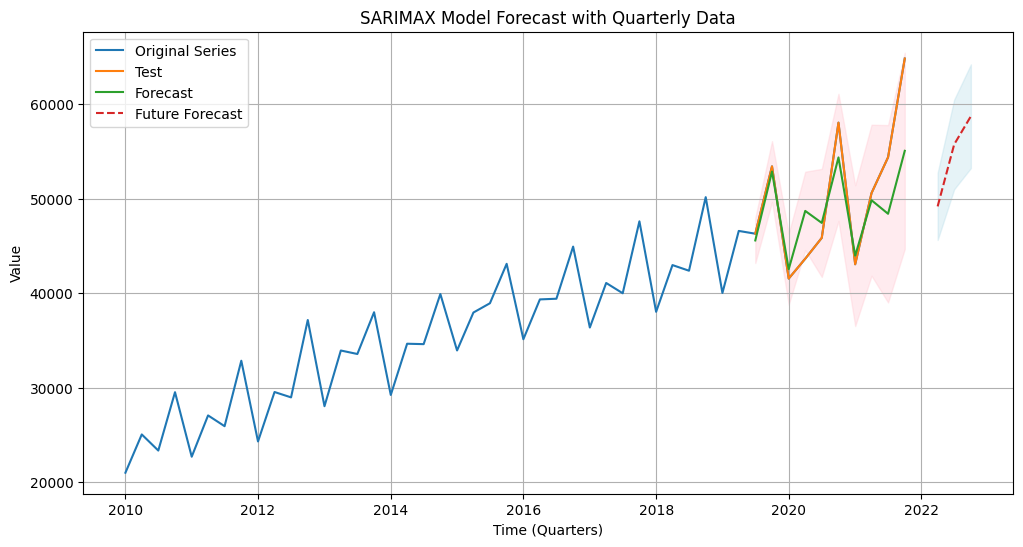

({'RMSE': 4194.2808067498145,
  'MAE': 2999.1395760281325,
  'MAPE': 5.601779264385645},
 2022-03-31    49184.709399
 2022-06-30    55743.732569
 2022-09-30    58727.762196
 Freq: QE-DEC, Name: predicted_mean, dtype: float64)

In [ ]:
sarimax_pipeline(df['srd(cfo)'], 1,0,0,1,0,0,4)